# MNIST Classification using TensorFlow Core

In [1]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, BatchNormalization, MaxPool2D, Dropout
from tensorflow.keras import Model
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255, x_test/255

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [3]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [4]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(64, 3, activation='relu')
        self.pool1 = MaxPool2D(pool_size=(2, 2), strides=(2, 2))
        self.conv3 = Conv2D(64, 3, activation='relu')
        self.pool2 = MaxPool2D(pool_size=(2, 2), strides=(2, 2))
        
        self.flatten = Flatten()
        self.d1 = Dense(512, activation='relu')
        self.drop1 = Dropout(0.2)
        self.d2 = Dense(128, activation='relu')
        self.drop2 = Dropout(0.1)        
        self.d3 = Dense(10)
        
    def call(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool1(self.conv2(x))
        x = self.pool2(self.conv3(x))
        
        x = self.flatten(x)
        x = self.d1(x)
        x = self.drop1(x)
        x = self.drop2(self.d2(x))
        
        return self.d3(x)

model = MyModel()

In [5]:
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [6]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [7]:
@tf.function
def train(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_func(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, predictions)
        

In [8]:
@tf.function
def test(images, labels):
    predictions = model(images, training=False)
    loss = loss_func(label, predictions)
    
    test_loss(loss)
    test_accuracy(labels, predictions)

In [9]:
EPOCHS = 10

train_loss_list = []
test_loss_list = []
train_accuracy_list = []
test_accuracy_list = []

for epoch in range(EPOCHS):
    train_loss.reset_states()
    test_loss.reset_states()
    train_accuracy.reset_states()
    test_accuracy.reset_states()
    
    for images, labels in train_data:
        train(images, labels)
    
    for image, label in test_data:
        test(image, label)
    
    train_loss_list.append(train_loss.result())
    test_loss_list.append(test_loss.result())
    train_accuracy_list.append(train_accuracy.result())
    test_accuracy_list.append(test_accuracy.result())
        
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        test_loss.result(),
                        test_accuracy.result() * 100))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.1160593256354332, Accuracy: 96.54166412353516, Test Loss: 13.152195930480957, Test Accuracy: 98.68000030517578
Epoch 2, Loss: 0.04869762063026428, Accuracy: 98.53500366210938, Test Loss: 15.444615364074707, Test Accuracy: 99.08999633789062
Epoch 3, Loss: 0.037768445909023285, Accuracy: 98.9433364868164, Test Loss: 19.364654541015625, Test Accuracy: 98.97000122070312
Epoch 4, Loss: 0.029975909739732742, Accuracy: 99.125, Test Loss: 16.1212100982666, Test Accuracy: 99.01000213623047
Epoch

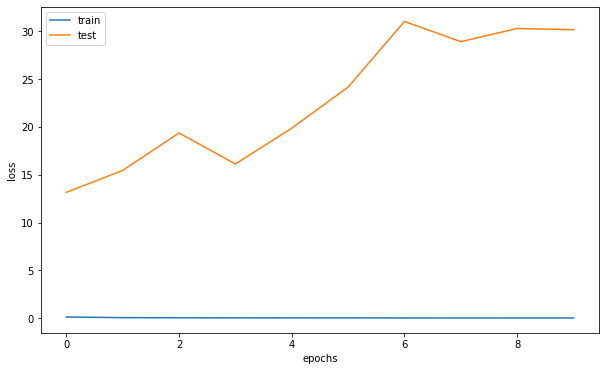

In [10]:
plt.figure(figsize=[10, 6])
plt.plot(np.arange(EPOCHS), train_loss_list)
plt.plot(np.arange(EPOCHS), test_loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'test'])

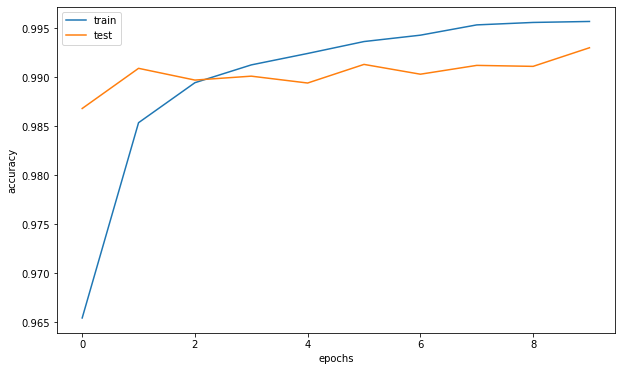

In [11]:
plt.figure(figsize=[10, 6])
plt.plot(np.arange(EPOCHS), train_accuracy_list)
plt.plot(np.arange(EPOCHS), test_accuracy_list)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])